In [ ]:
#!pip install seaborn

In [ ]:
#!pip install dataprep

In [ ]:
#!pip install missingno

In [63]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import missingno as msno
#from dataprep.eda import plot, plot_correlation, create_report, plot_missing

from typing import List

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import lightgbm as lgb

## Загрузка данных

In [64]:
path = 'data'

In [223]:
train = pd.read_csv(os.path.join(path, 'train.csv'))
test = pd.read_csv(os.path.join(path, 'test.csv'))

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [224]:
train.head()

,city,floor,id,lat,lng,osm_amenity_points_in_0.001,osm_amenity_points_in_0.005,osm_amenity_points_in_0.0075,osm_amenity_points_in_0.01,osm_building_points_in_0.001,...,reform_mean_floor_count_1000,reform_mean_floor_count_500,reform_mean_year_building_1000,reform_mean_year_building_500,region,total_square,street,date,realty_type,price_type
0,Пермь,NaN,COL_0,57.998207,56.292797,4,19,35,52,0,...,5.762963,5.530612,1964.118519,1960.959184,Пермский край,32.0,S27289,2020-01-05,10,0
1,Шатура,NaN,COL_1,55.574284,39.543835,3,24,37,59,0,...,2.894366,3.527778,1952.321678,1957.222222,Московская область,280.0,S17052,2020-01-05,10,0
2,Ярославль,NaN,COL_2,57.619140,39.850525,1,30,67,128,0,...,6.141414,7.222222,1968.150000,1973.370370,Ярославская область,297.4,S16913,2020-01-05,110,0
3,Новокузнецк,NaN,COL_3,53.897083,87.108604,0,0,5,21,0,...,8.581081,9.000000,1992.716216,2014.000000,Кемеровская область,190.0,S10148,2020-01-05,110,0
4,Москва,NaN,COL_4,55.802590,37.487110,1,23,64,153,0,...,7.263889,5.684211,1963.229167,1960.500000,Москва,60.2,S1338,2020-01-05,10,0


In [225]:
test.head()

,city,floor,id,osm_amenity_points_in_0.001,osm_amenity_points_in_0.005,osm_amenity_points_in_0.0075,osm_amenity_points_in_0.01,osm_building_points_in_0.001,osm_building_points_in_0.005,osm_building_points_in_0.0075,...,reform_mean_year_building_1000,reform_mean_year_building_500,region,lat,lng,total_square,street,date,realty_type,price_type
0,Курск,1.0,COL_289284,7,55,85,117,0,0,0,...,1966.471591,1966.740260,Курская область,51.709255,36.147908,156.148996,S6983,2020-09-06,100,1
1,Сургут,1.0,COL_289305,8,70,112,140,0,0,0,...,1988.259259,1989.068182,Ханты-Мансийский АО,61.233240,73.462509,190.737943,S29120,2020-09-06,110,1
2,Тюмень,-1.0,COL_289318,3,28,67,122,0,0,0,...,1985.880282,1991.458333,Тюменская область,57.143110,65.554573,457.118051,S23731,2020-09-06,10,1
3,Иркутск,1.0,COL_289354,5,76,139,231,0,0,0,...,1947.073276,1941.657895,Иркутская область,52.281380,104.282975,66.503622,S14207,2020-09-06,100,1
4,Курск,NaN,COL_289399,8,105,189,279,0,0,2,...,1948.764151,1946.689655,Курская область,51.729706,36.194019,23.864915,S20658,2020-09-06,10,1


In [226]:
train.shape

(279792, 77)

In [227]:
test.shape

(2974, 76)

## Data processing

In [228]:
df = pd.concat([train, test], axis=0, ignore_index=True)
df

,city,floor,id,lat,lng,osm_amenity_points_in_0.001,osm_amenity_points_in_0.005,osm_amenity_points_in_0.0075,osm_amenity_points_in_0.01,osm_building_points_in_0.001,...,reform_mean_floor_count_1000,reform_mean_floor_count_500,reform_mean_year_building_1000,reform_mean_year_building_500,region,total_square,street,date,realty_type,price_type
0,Пермь,NaN,COL_0,57.998207,56.292797,4,19,35,52,0,...,5.762963,5.530612,1964.118519,1960.959184,Пермский край,32.000000,S27289,2020-01-05,10,0
1,Шатура,NaN,COL_1,55.574284,39.543835,3,24,37,59,0,...,2.894366,3.527778,1952.321678,1957.222222,Московская область,280.000000,S17052,2020-01-05,10,0
2,Ярославль,NaN,COL_2,57.619140,39.850525,1,30,67,128,0,...,6.141414,7.222222,1968.150000,1973.370370,Ярославская область,297.400000,S16913,2020-01-05,110,0
3,Новокузнецк,NaN,COL_3,53.897083,87.108604,0,0,5,21,0,...,8.581081,9.000000,1992.716216,2014.000000,Кемеровская область,190.000000,S10148,2020-01-05,110,0
4,Москва,NaN,COL_4,55.802590,37.487110,1,23,64,153,0,...,7.263889,5.684211,1963.229167,1960.500000,Москва,60.200000,S1338,2020-01-05,10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282761,Красноярск,4.0,COL_455089,55.978180,92.891457,0,3,6,16,0,...,5.730769,6.333333,1972.153846,1982.250000,Красноярский край,2149.546362,S2650,2020-12-27,100,1
282762,Томск,1.0,COL_455212,56.459183,84.979872,2,33,111,222,0,...,5.714286,5.882353,1972.260870,1973.460000,Томская область,359.371061,S11114,2020-12-27,10,1
282763,Калуга,-1.0,COL_455261,54.523247,36.295168,2,25,54,99,0,...,3.983871,4.909091,1966.390244,1966.904762,Калужская область,87.820453,S34005,2020-12-27,100,1
282764,Нижний Новгород,NaN,COL_455381,56.328236,43.990039,13,70,114,158,0,...,3.829268,4.529412,1938.331361,1946.529412,Нижегородская область,208.625735,S21753,2020-12-27,10,1


In [229]:
# замена
def floor_processing(df):
    floor_dict = {
        np.nan: 1,
        'цоколь': 1,
        '1 этаж': 1,
        'цоколь, 1': 1,
        '1': 1,
        '1.0': 1,

        'подвал': -1,
        '-1.0': -1,
        '-1': -1,

        '1, подвал': -0.5,
        'подвал , 1': -0.5,
        'подвал, 1': -0.5,

        '-2.0': -2,
        '-3.0': -3,

        '1,2': 1.5,
        '1, 2': 1.5,
        '4 этаж': 4,
    }

    df['floor'] = df['floor'].replace(floor_dict)

    # меняем нечиловые описания на нули https://stackoverflow.com/a/43744114
    df['floor'] = (
        pd.to_numeric(df['floor'],
                      errors='coerce')
          .fillna(0)
        )
    return df

In [230]:
df = floor_processing(df)

# Модель

In [73]:
THRESHOLD = 0.15
NEGATIVE_WEIGHT = 1.1

def deviation_metric_vec(y_true: np.array, y_pred: np.array) -> float:
    deviation = (y_pred - y_true) / np.maximum(1e-8, y_true)
    
    metr = deviation * 0.0 + 9
    
    metr[np.abs(deviation) <= THRESHOLD] = 0
    
    metr[deviation <= - 4 * THRESHOLD] = 9 * NEGATIVE_WEIGHT
    
    mask = (-4 * THRESHOLD < deviation) & (deviation < -THRESHOLD)
    metr[mask] = NEGATIVE_WEIGHT * ((deviation[mask] / THRESHOLD) + 1) ** 2
    
    mask = (deviation < 4 * THRESHOLD) & (deviation > THRESHOLD)
    metr[mask] = ((deviation[mask] / THRESHOLD) - 1) ** 2
    
    return metr.mean()

In [231]:
cat_feat = ['region', 'city', 'street', 'realty_type', 'osm_city_nearest_name', 'date']
cat_feat

['region', 'city', 'street', 'realty_type', 'osm_city_nearest_name', 'date']

In [232]:
def label_encoder(df, cat_feat):
    """
    Кодируем категориальные
    """
    le = preprocessing.LabelEncoder()
    for col in cat_feat:
        # уникальные значения по колонке
        values = df[col].unique()
        # Fit label encoder
        le.fit(values)
        # преобразуем 
        df[col] = le.transform(df[col])
        
    return df

In [233]:
label_encoder(df, cat_feat)

,city,floor,id,lat,lng,osm_amenity_points_in_0.001,osm_amenity_points_in_0.005,osm_amenity_points_in_0.0075,osm_amenity_points_in_0.01,osm_building_points_in_0.001,...,reform_mean_floor_count_1000,reform_mean_floor_count_500,reform_mean_year_building_1000,reform_mean_year_building_500,region,total_square,street,date,realty_type,price_type
0,3063,1.0,COL_0,57.998207,56.292797,4,19,35,52,0,...,5.762963,5.530612,1964.118519,1960.959184,31,32.000000,16168,0,0,0
1,4442,1.0,COL_1,55.574284,39.543835,3,24,37,59,0,...,2.894366,3.527778,1952.321678,1957.222222,25,280.000000,6512,0,0,0
2,4615,1.0,COL_2,57.619140,39.850525,1,30,67,128,0,...,6.141414,7.222222,1968.150000,1973.370370,48,297.400000,6367,0,2,0
3,2683,1.0,COL_3,53.897083,87.108604,0,0,5,21,0,...,8.581081,9.000000,1992.716216,2014.000000,14,190.000000,115,0,2,0
4,2465,1.0,COL_4,55.802590,37.487110,1,23,64,153,0,...,7.263889,5.684211,1963.229167,1960.500000,24,60.200000,3121,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282761,1946,4.0,COL_455089,55.978180,92.891457,0,3,6,16,0,...,5.730769,6.333333,1972.153846,1982.250000,19,2149.546362,15419,50,1,1
282762,3964,1.0,COL_455212,56.459183,84.979872,2,33,111,222,0,...,5.714286,5.882353,1972.260870,1973.460000,41,359.371061,1028,50,0,1
282763,1511,-1.0,COL_455261,54.523247,36.295168,2,25,54,99,0,...,3.983871,4.909091,1966.390244,1966.904762,12,87.820453,22665,50,1,1
282764,2624,1.0,COL_455381,56.328236,43.990039,13,70,114,158,0,...,3.829268,4.529412,1938.331361,1946.529412,26,208.625735,10937,50,0,1


In [234]:
df[cat_feat]

,region,city,street,realty_type,osm_city_nearest_name,date
0,31,3063,16168,0,109,0
1,25,4442,6512,0,104,0
2,48,4615,6367,2,167,0
3,14,2683,115,2,89,0
4,24,2465,3121,0,156,0
...,...,...,...,...,...,...
282761,19,1946,15419,1,64,50
282762,41,3964,1028,0,147,50
282763,12,1511,22665,1,49,50
282764,26,2624,10937,0,87,50


In [235]:
TARGET = 'per_square_meter_price'

In [236]:
train = df.iloc[:279792].copy()
print(train.shape)
train.head()

(279792, 77)


,city,floor,id,lat,lng,osm_amenity_points_in_0.001,osm_amenity_points_in_0.005,osm_amenity_points_in_0.0075,osm_amenity_points_in_0.01,osm_building_points_in_0.001,...,reform_mean_floor_count_1000,reform_mean_floor_count_500,reform_mean_year_building_1000,reform_mean_year_building_500,region,total_square,street,date,realty_type,price_type
0,3063,1.0,COL_0,57.998207,56.292797,4,19,35,52,0,...,5.762963,5.530612,1964.118519,1960.959184,31,32.0,16168,0,0,0
1,4442,1.0,COL_1,55.574284,39.543835,3,24,37,59,0,...,2.894366,3.527778,1952.321678,1957.222222,25,280.0,6512,0,0,0
2,4615,1.0,COL_2,57.619140,39.850525,1,30,67,128,0,...,6.141414,7.222222,1968.150000,1973.370370,48,297.4,6367,0,2,0
3,2683,1.0,COL_3,53.897083,87.108604,0,0,5,21,0,...,8.581081,9.000000,1992.716216,2014.000000,14,190.0,115,0,2,0
4,2465,1.0,COL_4,55.802590,37.487110,1,23,64,153,0,...,7.263889,5.684211,1963.229167,1960.500000,24,60.2,3121,0,0,0


In [237]:
test = df.iloc[279792:].copy()
test.drop([TARGET], axis=1, inplace=True)
print(test.shape)
test.head()

(2974, 76)


,city,floor,id,lat,lng,osm_amenity_points_in_0.001,osm_amenity_points_in_0.005,osm_amenity_points_in_0.0075,osm_amenity_points_in_0.01,osm_building_points_in_0.001,...,reform_mean_floor_count_1000,reform_mean_floor_count_500,reform_mean_year_building_1000,reform_mean_year_building_500,region,total_square,street,date,realty_type,price_type
279792,2059,1.0,COL_289284,51.709255,36.147908,7,55,85,117,0,...,4.325000,4.211268,1966.471591,1966.740260,20,156.148996,26162,34,1,1
279793,3801,1.0,COL_289305,61.233240,73.462509,8,70,112,140,0,...,5.389831,5.500000,1988.259259,1989.068182,46,190.737943,17948,34,2,1
279794,4095,-1.0,COL_289318,57.143110,65.554573,3,28,67,122,0,...,7.915493,8.250000,1985.880282,1991.458333,43,457.118051,12853,34,0,1
279795,1385,1.0,COL_289354,52.281380,104.282975,5,76,139,231,0,...,3.276860,3.012048,1947.073276,1941.657895,10,66.503622,3905,34,1,1
279796,2059,1.0,COL_289399,51.729706,36.194019,8,105,189,279,0,...,4.346154,4.827586,1948.764151,1946.689655,20,23.864915,9920,34,0,1


In [238]:
X_train, X_test, y_train, y_test = train_test_split(train.drop([TARGET, 'id'], axis=1), train[TARGET], 
                                                    test_size=0.25, random_state=42, shuffle=True)

In [239]:
X_train.shape, y_train.shape

((209844, 75), (209844,))

In [240]:
X_test.shape, y_test.shape

((69948, 75), (69948,))

In [241]:
lgb_params = { 
     'boosting_type': 'gbdt',
#     'n_estimators': 10000,
#     'learning_rate': 0.05134, # default = 0.1, constraints: learning_rate > 0.0
#     'num_leaves': 10, # default = 31
#     'min_data_in_leaf':10000, # default = 20
#     'feature_fraction':0.1, # default = 1.0, constraints: 0.0 < feature_fraction <= 1.0
#     'max_depth': 10,
#     'subsample_for_bin': 240000,
#     'lambda_l1': 2,
#     'lambda_l2': 0,
#     'colsample_bytree': 0.508716,
#     'min_split_gain': 0.024766,
#     'subsample': 0.7,
#     'is_unbalance': False,
     'random_state': 27,
     'silent': -1,
     'verbose': -1
}

model = lgb.LGBMRegressor(**lgb_params)
model.fit(
    X=X_train, 
    y=y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_names=["train", "test"],
    early_stopping_rounds=10,
    #eval_metric=smape,
    verbose=25
)

Training until validation scores don't improve for 10 rounds
[25]	train's l2: 9.61002e+09	test's l2: 9.78031e+09
[50]	train's l2: 8.05867e+09	test's l2: 8.35521e+09
[75]	train's l2: 7.37133e+09	test's l2: 7.80677e+09
[100]	train's l2: 6.94208e+09	test's l2: 7.45886e+09
Did not meet early stopping. Best iteration is:
[100]	train's l2: 6.94208e+09	test's l2: 7.45886e+09


LGBMRegressor(random_state=27, silent=-1, verbose=-1)

In [243]:
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)
submission = model.predict(test.drop(['id'], axis=1))

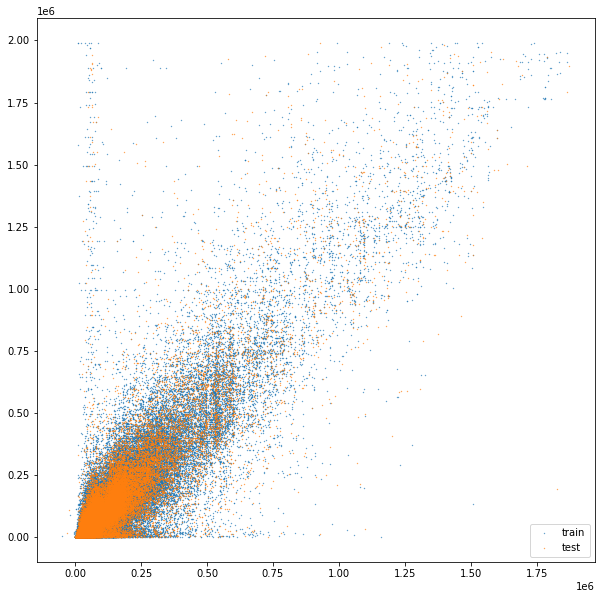

In [244]:
plt.figure(figsize=(10,10));
plt.scatter(train_predictions, y_train, label='train', s=0.1)
plt.scatter(test_predictions, y_test, label='test', s=0.1
#         label='test',
#         s=1, c='green', linewidth=2, linestyle='dashed',
#         marker='o', markerfacecolor='blue', markersize=12
        )
plt.legend();
#plt.show();

In [248]:
submission

array([48096.12552574, 56652.49080352, 39897.2827611 , ...,
       40336.52433954, 65389.02661967, 63074.98024234])

In [249]:
submission.shape

(2974,)

In [270]:
submit = pd.DataFrame()
submit['id'] = test['id'].copy()
submit['per_square_meter_price'] = submission
submit

,id,per_square_meter_price
279792,COL_289284,48096.125526
279793,COL_289305,56652.490804
279794,COL_289318,39897.282761
279795,COL_289354,75630.317431
279796,COL_289399,84650.144878
...,...,...
282761,COL_455089,29157.624531
282762,COL_455212,48562.257417
282763,COL_455261,40336.524340
282764,COL_455381,65389.026620


In [271]:
submit.to_csv('solution_03.csv', index=False)
#test_predictions.to_csv('solution_03.csv', index=False)

In [ ]:
def make_cross_validation(X: pd.DataFrame,
                          y: pd.Series,
                          estimator: object,
                          metric: callable,
                          cv_strategy):
    """
    Кросс-валидация.

    Parameters
    ----------
    X: pd.DataFrame
        Матрица признаков.

    y: pd.Series
        Вектор целевой переменной.

    estimator: callable
        Объект модели для обучения.

    metric: callable
        Метрика для оценки качества решения.
        Ожидается, что на вход будет передана функция,
        которая принимает 2 аргумента: y_true, y_pred.

    cv_strategy: cross-validation generator
        Объект для описания стратегии кросс-валидации.
        Ожидается, что на вход будет передан объект типа
        KFold или StratifiedKFold.

    Returns
    -------
    oof_score: float
        Значение метрики качества на OOF-прогнозах.

    fold_train_scores: List[float]
        Значение метрики качества на каждом обучающем датасете кросс-валидации.

    fold_valid_scores: List[float]
        Значение метрики качества на каждом валидационном датасете кросс-валидации.

    oof_predictions: np.array
        Прогнозы на OOF.

    """
    estimators, fold_train_scores, fold_valid_scores = [], [], []
    oof_predictions = np.zeros(X.shape[0])

    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y.loc[train_idx], y.loc[valid_idx]

        estimator.fit(x_train, y_train)
        y_train_pred = estimator.predict(x_train)
        y_valid_pred = estimator.predict(x_valid)

        fold_train_scores.append(metric(y_train, y_train_pred))
        fold_valid_scores.append(metric(y_valid, y_valid_pred))
        oof_predictions[valid_idx] = y_valid_pred

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score = {round(fold_train_scores[fold_number], 4)}, "
            f"valid-score = {round(fold_valid_scores[fold_number], 4)}" 
        )
        print(msg)
        print("="*69)
        estimators.append(estimator)

    oof_score = metric(y, oof_predictions)
    print(f"CV-results train: {round(np.mean(fold_train_scores), 4)} +/- {round(np.std(fold_train_scores), 3)}")
    print(f"CV-results valid: {round(np.mean(fold_valid_scores), 4)} +/- {round(np.std(fold_valid_scores), 3)}")
    print(f"OOF-score = {round(oof_score, 4)}")

    return estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions

cv_strategy = KFold(n_splits=5, random_state=1)

estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation(
    data[numerical_features], data["y"], model, metric=r2_score, cv_strategy=cv_strategy
)